# Run training for Pine

In [1]:
import sys
import os
path_to_top_dir = "../"
# Dynamically add the `project` directory to the path
sys.path.append(os.path.abspath(path_to_top_dir))

In [2]:
os.path.abspath(path_to_top_dir)

'c:\\Users\\paulj\\Desktop\\prosjekt\\pom_cpu-model'

In [3]:
# Print current working directory
os.getcwd()

'c:\\Users\\paulj\\Desktop\\prosjekt\\pom_cpu-model\\runs'

In [4]:
# Import scent_gfn functions
from scent_gfn.fragments import FRAGMENTS, FRAGMENTS_OPENPOM_DATASET, FRAGMENTS_OPENPOM_VANILLA
from scent_gfn.molecule import MoleculeTrainer

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'
c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module impli

| **Parameter**                | **Value**      |
|------------------------------|----------------|
| Reward function type         | OpenPOM        |
| Similarity measure           | Cosine         |
| Graph building               | Fragments      |
| Iterations                   | 500            |
| Max number of nodes          | 6              |
| Illegal action logreward     | -100           |
| β                            | 1              |
| Large molecule penalty       | None           |

In [5]:
params = {
    "save_name": "pine1",
    "reward_func": "openpom", # structure, openpom
    "similarity": "cosine",
    "graph_building": FRAGMENTS,#FRAGMENTS,
    "iterations": 500,
    "max_nodes": 6,
    "illegal_logreward": -100,
    "beta": 1.0,
    "large_mol_pen": [None,None] # ["exponential", 15] , ["hard", 15], [None,None]
}

In [6]:
# Utilities
import warnings
import random
import datetime

# Data processing and file management
import pathlib
import pandas as pd
import json
import numpy as np

# Machine learning
import torch
from gflownet.config import init_empty, Config
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage, MolToImage


# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Run on cpu
dev = torch.device('cpu')

In [7]:
def get_pine_openpom_target():
    with open('../data/pine_target_2.json', 'r') as file:
        target = json.load(file)
    return [target]



In [8]:
def get_vanilla_test_and_training(split_ratio=0.7):
    df = pd.read_csv("../data/data.csv")
    vanilla_mols_df = df.loc[df['vanilla'] == 1]
    vanilla_smiles_trainig= list(vanilla_mols_df["nonStereoSMILES"])
    vanilla_smiles_trainig = random.sample(vanilla_smiles_trainig, round(len(vanilla_mols_df)*split_ratio))
    random.shuffle(vanilla_smiles_trainig)
    vanilla_smiles_test = []
    for i in vanilla_mols_df["nonStereoSMILES"]:
        if i not in vanilla_smiles_trainig:
            vanilla_smiles_test.append(i)
    return vanilla_smiles_trainig, vanilla_smiles_test

def get_vanillin():
    return ["COc1cc(C=O)ccc1O"]



In [9]:
target = get_pine_openpom_target() #get_vanillin()

In [10]:

# Initialize model
config = init_empty(Config())
config.print_every = 1
config.log_dir = f"{os.path.abspath(path_to_top_dir)}/results/{params['save_name']}_{datetime.datetime.now().strftime('%Y-%m-%d__%H_%M_%S')}"
config.device = dev
config.num_training_steps = params["iterations"]
config.num_workers = 0
config.num_validation_gen_steps = 1
config.overwrite_existing_exp=False
config.checkpoint_every = 100
config.algo.max_nodes = params["max_nodes"] #12 # 95 quantil
config.store_all_checkpoints = True
config.algo.illegal_action_logreward = params["illegal_logreward"]

if params["graph_building"] == None:
     trial = MoleculeTrainer(config,(params["reward_func"], params["similarity"],params["large_mol_pen"], target, params["beta"]), print_config=True) #,fragments=FRAGMENTS, print_config=True)
else:
    trial = MoleculeTrainer(config,(params["reward_func"], params["similarity"],params["large_mol_pen"], target, params["beta"]),fragments=params["graph_building"], print_config=True) #,fragments=FRAGMENTS, print_config=True)

OpenPOM input data detected ...
Reward function: reward_function_openpom | Similarity measure: cosine_similarity | exp_penalty: False | max_mol=None
Building molecules using fragments ...


Hyperparameters:

desc: noDesc
log_dir: c:\Users\paulj\Desktop\prosjekt\pom_cpu-model/results/pine1_2024-12-03__14_19_29
device: cpu
seed: 0
validate_every: 1000
checkpoint_every: 100
store_all_checkpoints: true
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 500
num_workers: 0
hostname: null
pickle_mp_messages: false
git_hash: f106cde
overwrite_existing_exp: false
algo:
  method: TB
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 6
  max_edges: 128
  illegal_action_logreward: -100.0
  train_random_action_prob: 0.0
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_mul

In [11]:
trial.run()

03/12/2024 14:19:30 - INFO - logger - Starting training


03/12/2024 14:19:37 - INFO - logger - iteration 1 : offline_loss:0.00 online_loss:2031.91 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.02 loss:2031.91 n_loss:0.00 tb_loss:2031.91 batch_entropy:27.85 traj_lens:10.95 grad_norm:509.86 grad_norm_clip:70.93 sampled_reward_avg:0.32 train_time:1.48 time_spent:6.91
03/12/2024 14:19:44 - INFO - logger - iteration 2 : offline_loss:0.00 online_loss:1583.34 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.06 loss:1583.34 n_loss:0.00 tb_loss:1583.34 batch_entropy:29.24 traj_lens:11.42 grad_norm:599.91 grad_norm_clip:71.77 sampled_reward_avg:0.41 train_time:1.59 time_spent:7.31
03/12/2024 14:19:50 - INFO - logger - iteration 3 : offline_loss:0.00 online_loss:1949.49 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.09 loss:1949.49 n_loss:0.00 tb_loss:1949

In [21]:
with open(os.path.join(config.log_dir, "params.json"), "w+") as file:
    json.dump(params,file)

with open(os.path.join(config.log_dir, "target.json"), "w+") as file:
    json.dump(target,file)

In [22]:
state = {
    "models_state_dict": [trial.model.state_dict()],
    "cfg": trial.cfg,
    "env_ctx": trial.model.env_ctx,
    #"model": trial.model,
}
if trial.sampling_model is not trial.model:
    state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
with open(fn, "wb") as fd:
    torch.save(
        state,
        fd,
    )

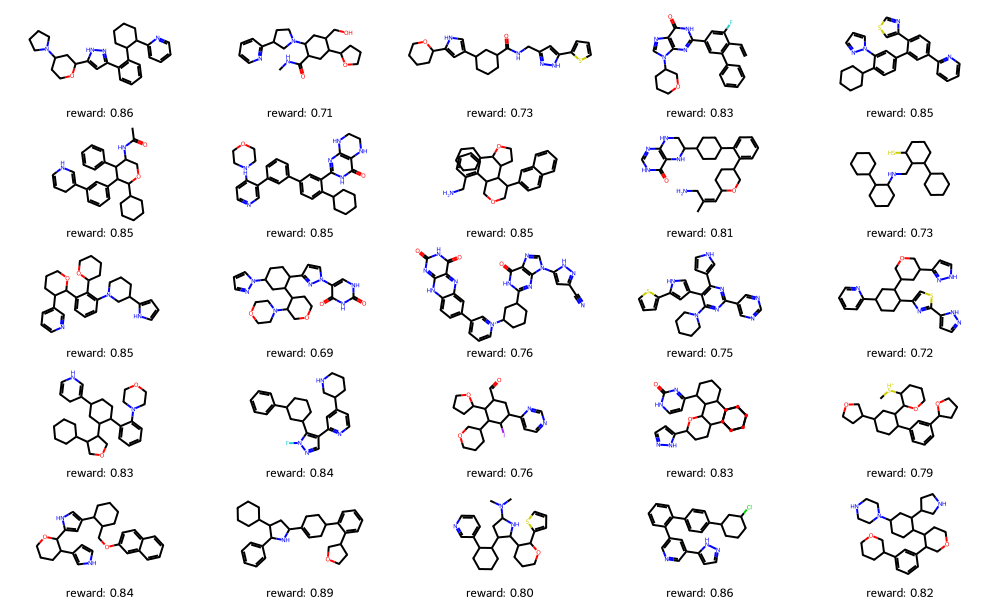

In [12]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
log_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
index = 0
rewards = []
for i in is_valid:
    if i:
        rewards.append(list(log_rewards)[index])
        index += 1 
    else:
        rewards.append(0)

MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r}' if r==0 else f'reward: {r.exp().item():.2f}' for r in rewards[:25]])

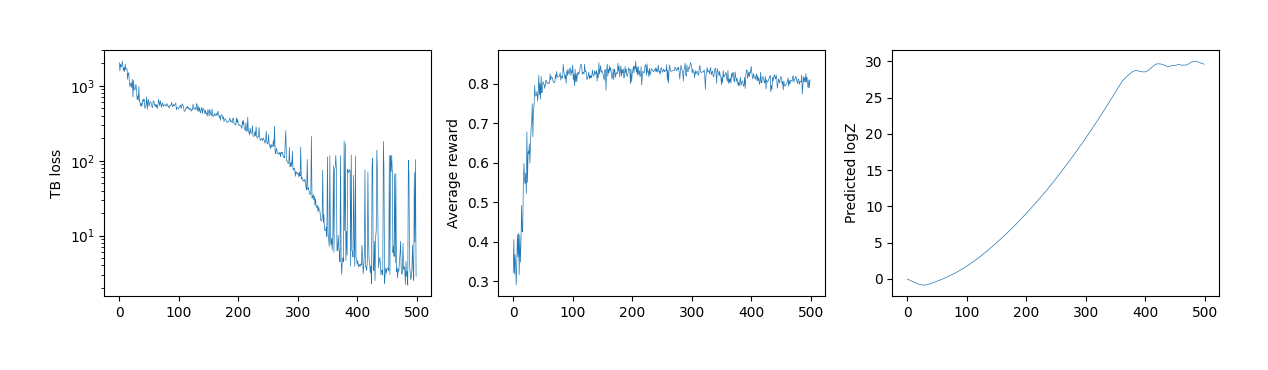

In [17]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator
cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[1].set_ylabel('Average reward')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')])
ax[2].set_ylabel('Predicted logZ')
pp.tight_layout()

In [16]:
tags = ea.Tags()
print("Available tags:", tags)

Available tags: {'images': [], 'audio': [], 'histograms': [], 'scalars': ['train_offline_loss', 'train_online_loss', 'train_reward_loss', 'train_invalid_trajectories', 'train_invalid_logprob', 'train_invalid_losses', 'train_backward_vs_unif', 'train_logZ', 'train_loss', 'train_n_loss', 'train_tb_loss', 'train_batch_entropy', 'train_traj_lens', 'train_grad_norm', 'train_grad_norm_clip', 'train_sampled_reward_avg', 'train_train_time', 'train_time_spent'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


In [14]:
from pycirclize import Circos
import pandas as pd
import matplotlib.pyplot as plt
from pom_models.functions import fragance_propabilities_from_smiles
from rdkit import Chem
import numpy as np

In [15]:
indices = np.argsort(-np.array(target))
indices

array([[ 64, 137,  60,  53,  51,  21,  45,  82,  50, 119, 126,  38, 123,
          4,  30,  99,  31,  58,  23, 110, 125,  86,   5,  85,  73,  44,
         72, 128, 124,  87,  74,  14, 132,  78, 112,  98, 131,  10, 130,
          1,  88, 104,   9,  94,  83,  80, 133,  24,   6,  71,  90, 121,
         56, 117, 114,  75,  16,  69,  95, 107,  39, 135,  62, 134,  92,
         59,  47, 109,  66,   8, 105, 108,  65,   7, 118,  13, 103,  52,
         15,  67,  49, 101,  18,  33,  46,  96, 116,  77,  70,  37, 100,
        113,  41, 111, 106,  79,  93,  40,  28,  48, 102,  29,  26,  63,
         22,  91,  84,  57,  97,  35, 115, 127,  55,  61, 122,  12,   3,
         32,  68,  20,   2, 120,  81,  43,  34, 136,  11,  54,  27,  17,
         25,  19,  76, 129,   0,  42,  89,  36]], dtype=int64)

In [16]:
labels = df.keys()[2:]
labels

NameError: name 'df' is not defined

In [25]:
data_lst  = []
for i, obj in enumerate(objs):
    smiles = Chem.MolToSmiles(obj)
    probs = fragance_propabilities_from_smiles(smiles)[0]

    data_lst.append( [smiles] + list(probs))
result_df = pd.DataFrame(
    data=data_lst,
    index=[i for i in range(len(data_lst))],
    columns=["smiles"]+list(labels)
    )
result_df.head()


,smiles,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,apricot,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
0,CC=Cc1ccc(-c2ccccc2)nc1-c1ccncc1C1CCC(c2ncccn2...,0.069776,0.153556,0.099827,0.402382,0.146904,0.439994,0.269701,0.069901,0.102523,...,0.175588,0.242265,0.143761,0.104901,0.078149,0.258849,0.196291,0.134099,0.126378,0.330897
1,C1=CNC=C(c2ccc(-c3cc(C4CCCCO4)ccc3C3COCC3c3ccc...,0.061807,0.138917,0.124202,0.366594,0.171433,0.492144,0.179461,0.060116,0.099165,...,0.149967,0.171135,0.157905,0.100572,0.074436,0.241837,0.186080,0.134500,0.104646,0.308324
2,NC(=O)n1cnc2c(C3CC(c4cc[nH]c4)OC(c4ccccn4)C3c3...,0.073982,0.152314,0.145837,0.444088,0.125184,0.408273,0.186333,0.074473,0.098976,...,0.179454,0.264533,0.154011,0.103656,0.058125,0.254636,0.147292,0.145878,0.148205,0.328596
3,[NH3+]Cc1nc(-c2cscn2)ncc1-c1cccc(-c2cccc(C3CCC...,0.071527,0.139928,0.113312,0.363613,0.194153,0.484348,0.241197,0.071331,0.123056,...,0.179949,0.174847,0.166743,0.112877,0.088852,0.229042,0.239815,0.137551,0.136907,0.318456
4,O=c1[nH]c(-c2cccc(-c3cccc(-c4ccc(C5CCCCC5C5CCC...,0.066674,0.139203,0.149508,0.381778,0.153466,0.466547,0.176261,0.062686,0.093575,...,0.170937,0.201472,0.193817,0.102865,0.067999,0.226404,0.163439,0.134856,0.116684,0.330685


In [68]:
target_df = pd.DataFrame(
    data=[["target"] + list(target)],
    columns=result_df.keys(),
    index=["Target"]
)
target_df

,smiles,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,apricot,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
Target,target,0.060157,0.209652,0.083372,0.088339,0.336117,0.268335,0.187134,0.141956,0.144496,...,0.256422,0.063885,0.211703,0.215956,0.225055,0.188657,0.149626,0.152026,0.074805,0.561436


In [30]:
most_important_indicies = indices[:8]
most_important_keys = []
for i in most_important_indicies:
    most_important_keys.append(labels[i])
most_important_keys

['herbal',
 'woody',
 'green',
 'fruity',
 'fresh',
 'camphoreous',
 'earthy',
 'mint']

In [79]:
rewards_plot = [f'{r}' if r==-1 else f'{r.exp().item():.2f}' for r in rewards[:25]]
rewards_plot

['0.70',
 '0.73',
 '0.74',
 '0.72',
 '0.75',
 '0.78',
 '0.74',
 '0.73',
 '0.73',
 '0.76',
 '0.74',
 '0.79',
 '0.72',
 '0.80',
 '0.76',
 '0.75',
 '0.73',
 '-1',
 '0.72',
 '0.68',
 '0.78',
 '0.75',
 '0.74',
 '0.71',
 '0.76']

In [82]:
plot_df = result_df[most_important_keys].set_index(pd.Series([f"{i+1} r:{rewards_plot[i]}" for i in range(len(result_df["smiles"]))]))
plot_df

,herbal,woody,green,fruity,fresh,camphoreous,earthy,mint
1 r:0.70,0.368094,0.330897,0.425910,0.443748,0.267390,0.169610,0.353724,0.178364
2 r:0.73,0.294593,0.308324,0.322688,0.410055,0.213210,0.166270,0.292193,0.181642
3 r:0.74,0.290509,0.328596,0.285294,0.421802,0.205202,0.155920,0.271813,0.160209
4 r:0.72,0.358809,0.318456,0.468388,0.432952,0.271824,0.206908,0.414255,0.195107
5 r:0.75,0.287300,0.330685,0.311546,0.412037,0.208565,0.172571,0.313930,0.193488
6 r:0.78,0.182618,0.203277,0.165164,0.235379,0.100871,0.091571,0.176723,0.161200
7 r:0.74,0.275967,0.296983,0.258811,0.400231,0.221381,0.160613,0.215575,0.227584
8 r:0.73,0.326077,0.303185,0.382644,0.417231,0.253960,0.192523,0.345738,0.208983
9 r:0.73,0.310999,0.304116,0.349419,0.413104,0.237467,0.186510,0.310535,0.218014
10 r:0.76,0.253020,0.347671,0.213475,0.381569,0.169357,0.134993,0.257461,0.165206


In [69]:
plot_target_df = target_df[most_important_keys]
plot_target_df

,herbal,woody,green,fruity,fresh,camphoreous,earthy,mint
Target,0.615864,0.561436,0.519596,0.51449,0.51066,0.5034,0.495063,0.460149


In [ ]:
plot_df.loc["target"] = []

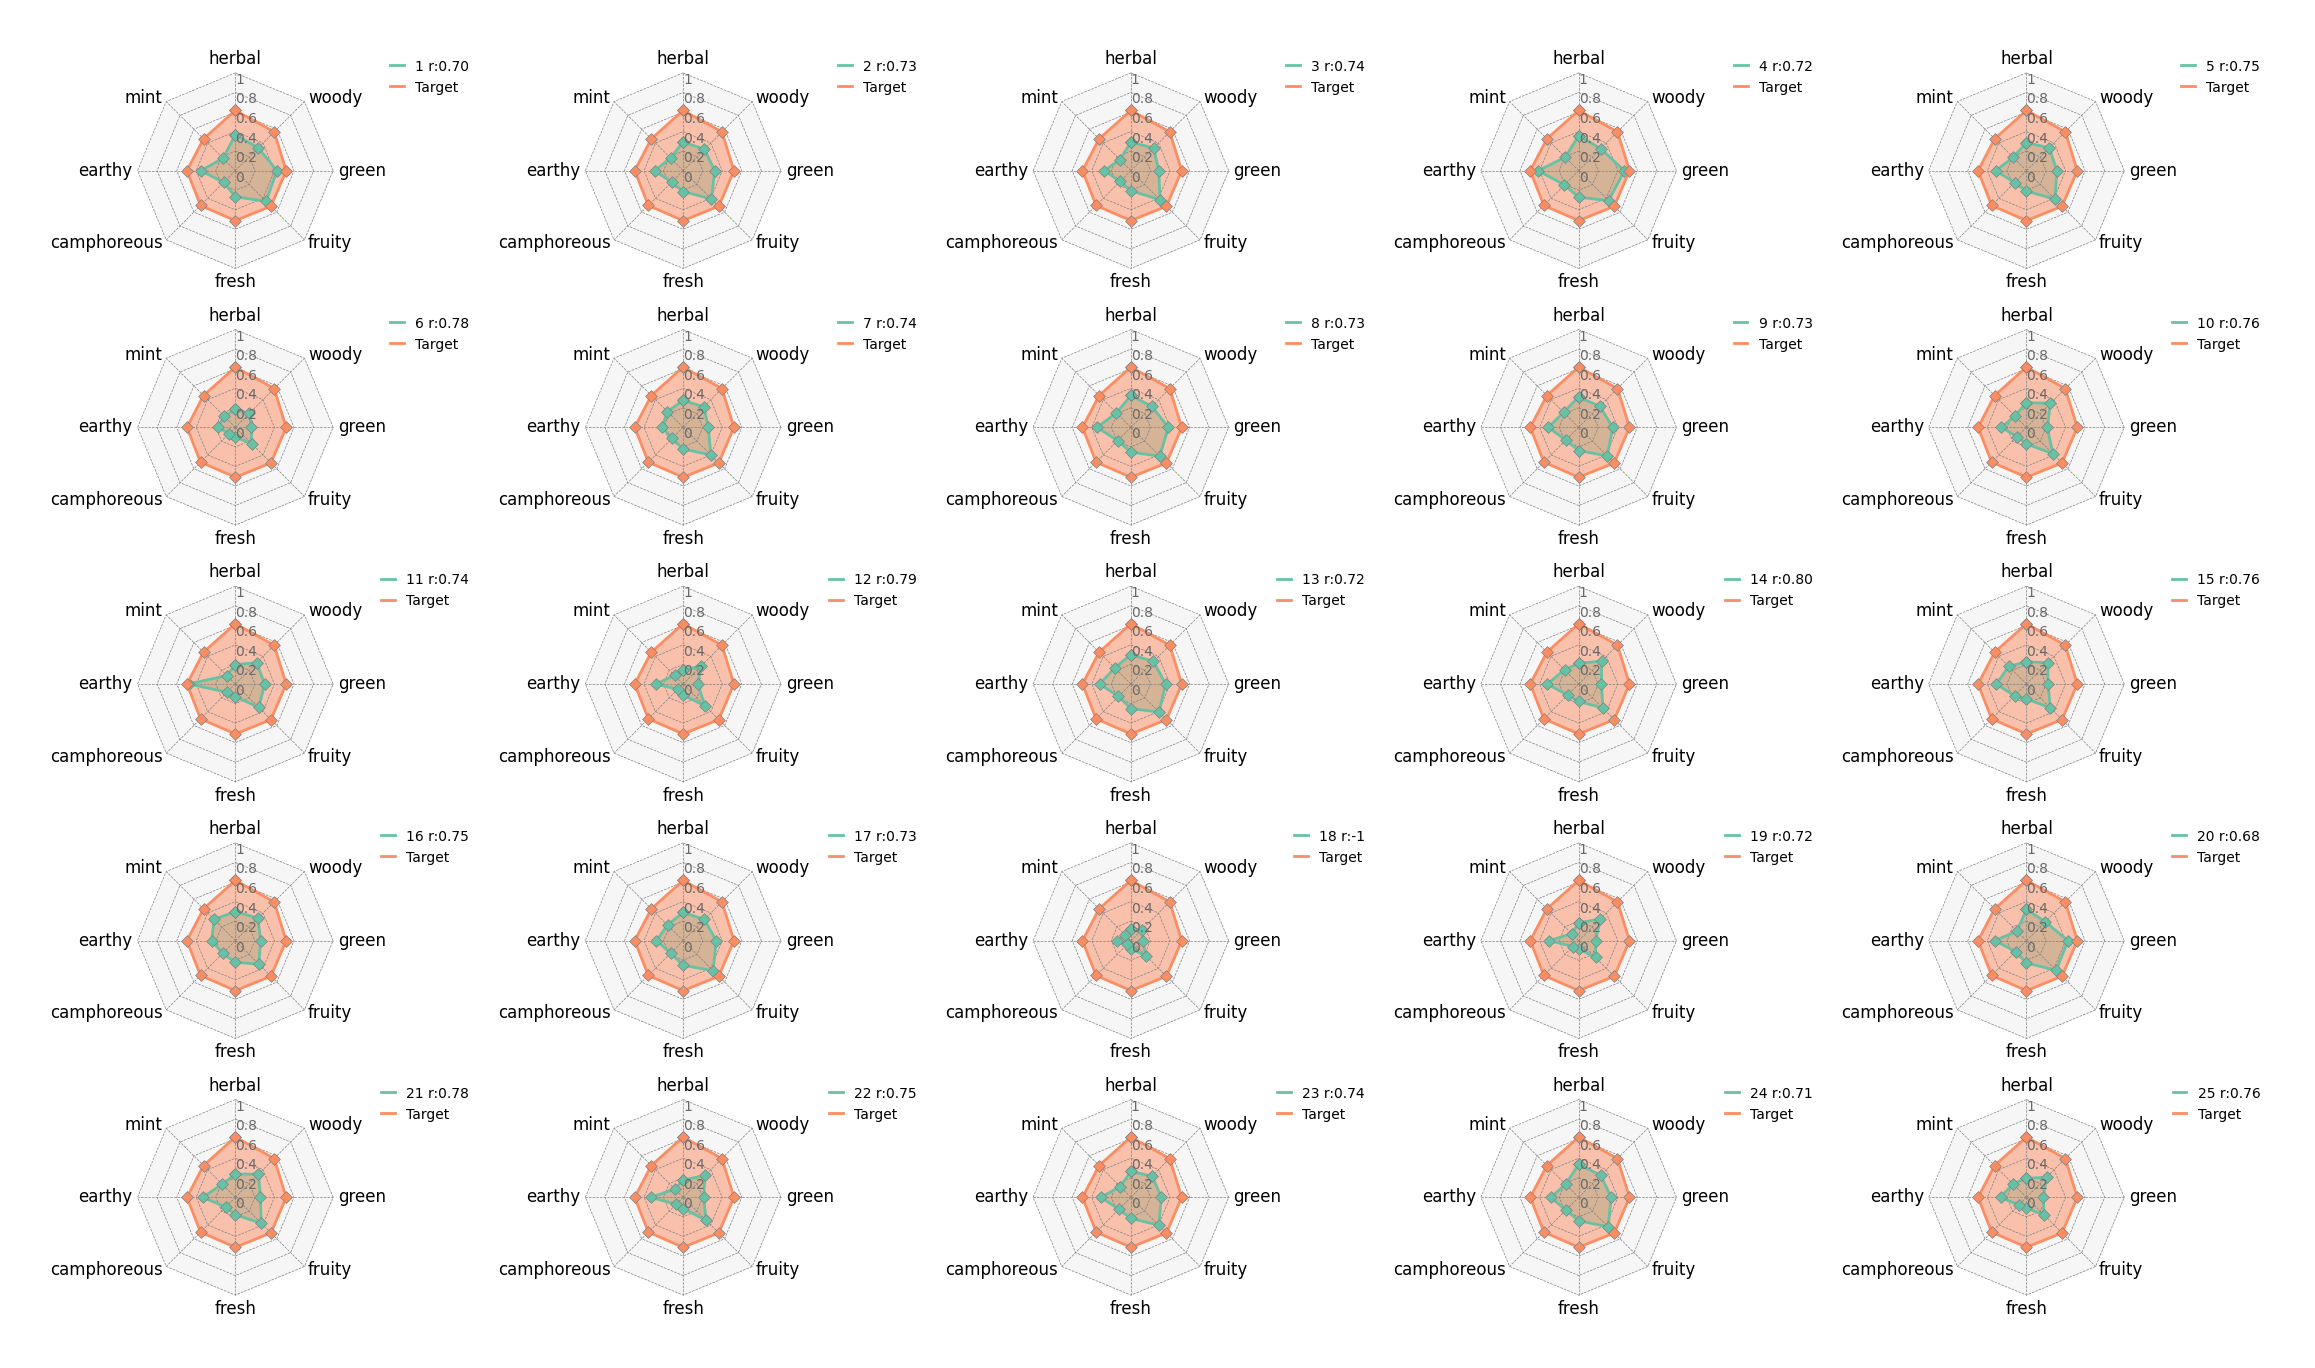

In [83]:


# Create 5 x 5 subplots
fig = plt.figure(figsize=(26, 16), dpi=100)
fig.subplots(5, 5, subplot_kw=dict(polar=True))
fig.subplots_adjust(wspace=1, hspace=0.25)

# Plot radar chart into subplots for each target
for target_name, ax in zip(plot_df.index, fig.axes):
    target_df = plot_df.loc[[target_name]]
    target_df = pd.concat([target_df, plot_target_df])
    # Initialize Circos instance for radar chart plot
    circos = Circos.radar_chart(
        target_df,
        vmax=1,
        marker_size=6,
        #cmap=dict(Hero="salmon", Warrior="skyblue", Wizard="lime", Assassin="magenta"),
        grid_interval_ratio=0.2,
        line_kws_handler=lambda _: dict(lw=2, ls="solid"),
        marker_kws_handler=lambda _: dict(marker="D", ec="grey", lw=0.5),
    )

    # Plot figure & set legend on upper right
    circos.plotfig(ax=ax)
    circos.ax.legend(loc="upper right", fontsize=10,bbox_to_anchor=(1.7, 1.1))

In [78]:
np.array(result_df[labels].sum())/len(result_df[labels])

array([0.05995543, 0.11770916, 0.15727852, 0.31326059, 0.12783672,
       0.3747793 , 0.16163549, 0.05580204, 0.08372282, 0.24644029,
       0.2505292 , 0.05264592, 0.17609397, 0.06224182, 0.13956971,
       0.24895823, 0.09086286, 0.08057499, 0.3823027 , 0.1737732 ,
       0.12967977, 0.14860569, 0.25545275, 0.07475504, 0.13512743,
       0.06313413, 0.15046977, 0.18489482, 0.20927325, 0.20088501,
       0.10334121, 0.14020291, 0.1273722 , 0.21772644, 0.17441086,
       0.30895635, 0.04945072, 0.17386217, 0.15681252, 0.1290583 ,
       0.33909127, 0.18139683, 0.04622186, 0.13549076, 0.20057446,
       0.29855117, 0.13621598, 0.16909724, 0.12709749, 0.21577373,
       0.33544526, 0.1880733 , 0.09973023, 0.36708736, 0.16353609,
       0.09104607, 0.15215756, 0.13582535, 0.1128882 , 0.13432352,
       0.28161418, 0.17359337, 0.18758734, 0.20311867, 0.25833598,
       0.25197047, 0.1435107 , 0.10136159, 0.04503134, 0.10612095,
       0.11025929, 0.07581776, 0.13877815, 0.18894821, 0.06013

In [90]:
import seaborn as sns

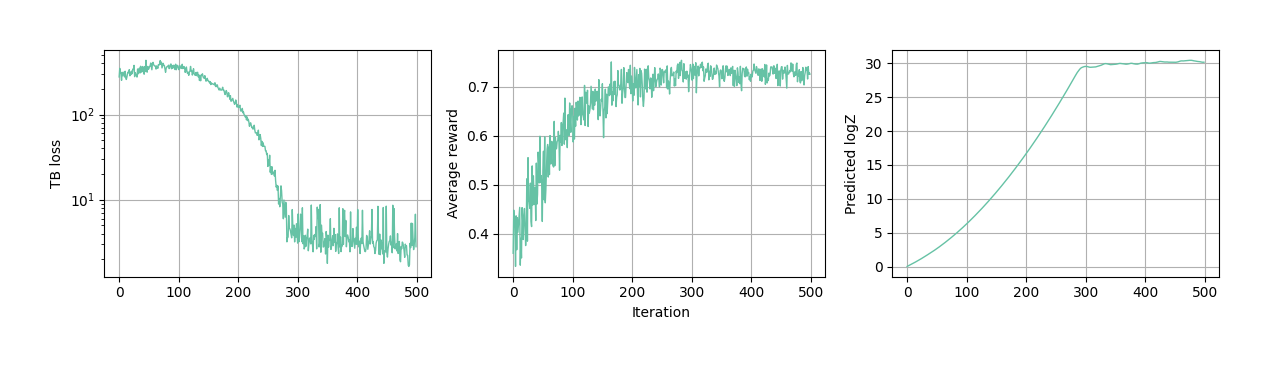

In [98]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator
cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')], color=sns.color_palette("Set2")[0],linewidth=1)
ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[0].grid()
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')], color=sns.color_palette("Set2")[0],linewidth=1)
ax[1].set_ylabel('Average reward')
ax[1].set_xlabel('Iteration')
ax[1].grid()
ax[2].plot([i.value for i in ea.Scalars('train_logZ')], color=sns.color_palette("Set2")[0],linewidth=1)
ax[2].set_ylabel('Predicted logZ')
ax[2].grid()
pp.tight_layout()
plt.savefig("images/pine_run_plots.pdf")